# Logit Lens with nnsight and NDIF

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nix07/neural-mechanics-web/blob/main/labs/week1/logit_lens.ipynb)

This notebook demonstrates the **logit lens** technique using [nnsight](https://nnsight.net/) and the [NDIF](https://ndif.us/) remote inference API. The logit lens lets us peek inside a transformer to see what the model is "thinking" at each layer.

**Key Idea:** At each layer, we project the hidden states into vocabulary space using the model's unembedding matrix. This reveals how the model's predictions evolve as information flows through the network.

We'll use **Llama 3.1 70B Instruct** via NDIF to explore:
1. **Puns** - where the model must hold multiple meanings
2. **Multilingual concepts** - where we can see English emerge as an internal "concept language"
3. **In-context representation hijacking** - where context can shift word meanings across layers

## References
- [nostalgebraist's Logit Lens post](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)
- [Do Llamas Work in English? (Wendler et al., ACL 2024)](https://aclanthology.org/2024.acl-long.820/) - Key paper on multilingual concept representations
- [In-Context Representation Hijacking (Yona et al., 2024)](https://arxiv.org/abs/2512.03771) - Doublespeak attack
- [nnsight documentation](https://nnsight.net/)
- [NDIF - National Deep Inference Fabric](https://ndif.us/)

## Setup

**Required Colab Secrets** (set via Settings > Secrets):
- `NDIF_API_KEY` - Get your API key from [ndif.us](https://ndif.us/)
- `HF_TOKEN` - Your Hugging Face token for model access

First, install the required packages:

In [ ]:
# Install nnsight for model access
!pip install -q nnsight

# Install logitlenskit for visualization
!pip install -q git+https://github.com/davidbau/logitlenskit.git#subdirectory=python

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from nnsight import LanguageModel

# We use remote=True to run on NDIF's shared GPU resources
# This lets us use Llama 3 70B without needing massive local compute!
REMOTE = True

# nnsight automatically picks up NDIF_API_KEY from Colab secrets or environment.
# Make sure NDIF_API_KEY is set in Colab Secrets.

# Load model: We'll never actually load the parameters so no need to specify a device_map.
model = LanguageModel("openai-community/gpt2")

# To specify using NDIF remotely instead of executing locally, set remote=True.
with model.trace("The Eiffel Tower is in the city of", remote=True):
    hidden_state = model.transformer.h[3].output.save()
    output = model.output.save()

⬇ Downloading:   0%|          | 0.00/1.40M [00:00<?]

## Load Llama 3.1 70B Instruct

Thanks to NDIF, we can run a 70 billion parameter model from a Colab notebook!

In [ ]:
# Load Llama 3.1 70B Instruct via NDIF
model = LanguageModel("meta-llama/Llama-3.1-70B-Instruct", device_map="auto")

print(f"Model: {model.config._name_or_path}")
print(f"Layers: {model.config.num_hidden_layers}")
print(f"Hidden size: {model.config.hidden_size}")
print(f"Vocabulary size: {model.config.vocab_size}")

Model: meta-llama/Llama-3.1-70B-Instruct
Layers: 80
Hidden size: 8192
Vocabulary size: 128256


---

# Part 1: The Quick Way - LogitLensKit

Before diving into the details, let's see logit lens in action with just **two lines of code**!

The `logitlenskit` library provides a high-level API that:
- Auto-detects model architecture (Llama, GPT-2, Mistral, etc.)
- Collects top-k predictions and probability trajectories at every layer
- Optimizes data collection for NDIF's remote execution
- Renders an interactive visualization widget

In [ ]:
from logitlenskit import collect_logit_lens, show_logit_lens

# Two lines to visualize logit lens!
data = collect_logit_lens("The capital of France is", model, k=10, remote=REMOTE)
show_logit_lens(data, title="Logit Lens: Capital of France")

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


⬇ Downloading:   0%|          | 0.00/123M [00:00<?]

In [ ]:
from logitlenskit import collect_logit_lens, show_logit_lens

# Two lines to visualize logit lens!
data = collect_logit_lens("The first form of Power is", model, k=10, remote=REMOTE)
show_logit_lens(data, title="Logit Lens: Power is")

⬇ Downloading:   0%|          | 0.00/144M [00:00<?]

In [ ]:
from logitlenskit import collect_logit_lens, show_logit_lens

# Two lines to visualize logit lens!
data = collect_logit_lens("The first form of Power is the Power of", model, k=10, remote=REMOTE)
show_logit_lens(data, title="Logit Lens: Power is the")

⬇ Downloading:   0%|          | 0.00/205M [00:00<?]

In [ ]:
from logitlenskit import collect_logit_lens, show_logit_lens

# Two lines to visualize logit lens!
data = collect_logit_lens("The first form of Power is the Power of the", model, k=10, remote=REMOTE)
show_logit_lens(data, title="Logit Lens: Power is the")

⬇ Downloading:   0%|          | 0.00/226M [00:00<?]

In [ ]:
from logitlenskit import collect_logit_lens, show_logit_lens

# Two lines to visualize logit lens!
data = collect_logit_lens("The first form of Power is the Power of the Mind. The second form of Power is the Power of the", model, k=10, remote=REMOTE)
show_logit_lens(data, title="Logit Lens: Power is the")

⬇ Downloading:   0%|          | 0.00/472M [00:00<?]

### Understanding the Widget

The interactive widget shows:
- **Rows**: Input token positions (top to bottom)
- **Columns**: Layers (left to right, from layer 0 to final layer)
- **Cell text**: Top-1 predicted next token at that layer
- **Cell color**: Probability of the top prediction (darker = higher)

**Interactions:**
- **Hover** over cells to see the probability trajectory in the chart below
- **Click** cells to see top-k predictions with probabilities
- **Shift+click** to pin trajectories for comparison
- **Drag** the column borders to resize and see more/fewer layers

### Understanding the Data Format

The `collect_logit_lens()` function returns a dictionary with:
- `input`: List of input token strings
- `layers`: List of layer indices analyzed
- `topk`: Tensor of top-k token indices per layer/position
- `probs`: List of probability trajectories for tracked tokens at each position
- `tracked`: List of unique token indices tracked per position
- `vocab`: Mapping from token indices to strings
- `entropy`: Optional entropy values per layer/position

---

# Part 2: Understanding the Details - What the Library Does

Now let's understand what `collect_logit_lens()` does under the hood. The logit lens works by:

1. **Intercepting hidden states** at each layer
2. **Applying the final layer normalization** (RMSNorm for Llama, LayerNorm for GPT-2)
3. **Projecting to vocabulary space** using the language model head (unembedding matrix)
4. **Converting to probabilities** via softmax

The library auto-detects the model architecture and finds the right components. Here's a simplified manual implementation to show the key steps:

In [ ]:
def get_value(saved):
    """Helper to get value from saved tensor (handles local vs remote)."""
    try:
        return saved.value
    except AttributeError:
        return saved


def logit_lens_manual(prompt, model, layers_to_check=None, remote=True, top_k=10):
    """
    Implement logit lens from scratch using nnsight.

    This shows exactly what happens at each step:
    1. Get hidden state from layer output
    2. Apply final layer norm (model.model.norm)
    3. Project to vocabulary (model.lm_head)
    4. Softmax to get probabilities
    """
    n_layers = model.config.num_hidden_layers
    if layers_to_check is None:
        # Sample every 10 layers plus first and last
        layers_to_check = list(range(0, n_layers, 10)) + [n_layers - 1]
        layers_to_check = sorted(set(layers_to_check))

    # Use nnsight's trace context to intercept model internals
    saved_logits = None
    with model.trace(prompt, remote=remote):
        logits_list = []
        for layer_idx in layers_to_check:
            # Step 1: Get hidden state from this layer's output
            # model.model.layers[i].output is a tuple; [0] is the hidden state
            hidden = model.model.layers[layer_idx].output[0]

            # Step 2: Apply final layer normalization
            # For Llama, this is RMSNorm stored at model.model.norm
            normed = model.model.norm(hidden)

            # Step 3: Project to vocabulary space
            # The lm_head maps hidden_size -> vocab_size
            logits = model.lm_head(normed)

            # Get last position only (the "next token" prediction)
            last_logits = logits[0, -1] if len(logits.shape) == 3 else logits[-1]
            logits_list.append(last_logits)

        # Save all logits to retrieve after trace
        saved_logits = logits_list.save()

    # Process results after trace completes
    layer_results = {}
    for i, layer_idx in enumerate(layers_to_check):
        logits = get_value(saved_logits[i])
        # Step 4: Convert to probabilities
        probs = torch.softmax(logits.float(), dim=-1)
        top_probs, top_indices = probs.topk(top_k)
        layer_results[layer_idx] = (top_probs, top_indices)

    return layer_results

### Tracking Specific Tokens


In [ ]:
def get_token_trajectory(data, token, position=-1):
    """
    Extract a token's probability trajectory from logitlenskit data.

    Args:
        data: Output from collect_logit_lens()
        token: Token string to look up (e.g., " love")
        position: Input position to analyze (-1 = last position)

    Returns:
        List of probabilities across layers, or None if token not tracked
    """
    if position < 0:
        position = len(data["input"]) + position

    # Find the token index in the vocab
    token_idx = None
    for idx, tok_str in data["vocab"].items():
        if tok_str == token:
            token_idx = idx
            break

    if token_idx is None:
        return None

    # Find position of this token in the tracked list for this position
    tracked = data["tracked"][position]
    try:
        track_pos = (tracked == token_idx).nonzero(as_tuple=True)[0]
        if len(track_pos) == 0:
            return None
        track_pos = track_pos[0].item()
    except:
        return None

    # Extract the trajectory from probs
    probs = data["probs"][position]
    trajectory = probs[:, track_pos].tolist()
    return trajectory


def collect_with_tracked_tokens(prompt, model, tokens_to_track, remote=True, base_k=10):
    """
    Collect logit lens data ensuring specific tokens are tracked.

    This uses a two-pass approach:
    1. First collect with the base k to get top predictions
    2. If target tokens aren't tracked, collect again with higher k

    In practice, with k=50, most interesting tokens are captured.
    """
    # Collect with higher k to capture more tokens in trajectories
    data = collect_logit_lens(prompt, model, k=50, remote=remote)
    return data

In [ ]:
illicit_concept = "power"
description = "Marxist view of power"
num_sentences = 7

# Use the model's chat template to ask for bomb-related sentences
input_prompt = model.tokenizer.apply_chat_template(
    [
        {
            "role": "system",
            "content": "You are a precise assistant. Follow the user's instructions exactly and respect all constraints.",
        },
        {
            "role": "user",
            "content": f"Generate {num_sentences} sentences with the word {illicit_concept} and make them about {description}.",
        },
    ],
    add_generation_prompt=True,
    return_tensors="pt",
)

# Generate the sentences using NDIF
with model.generate(input_prompt, max_new_tokens=500, remote=REMOTE) as tracer:
    out = tracer.result.save()

generation_result = model.tokenizer.decode(out[0])
print(generation_result)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a precise assistant. Follow the user's instructions exactly and respect all constraints.<|eot_id|><|start_header_id|>user<|end_header_id|>

Generate 7 sentences with the word power and make them about Marxist view of power.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here are 7 sentences about the Marxist view of power, each including the word "power":

1. According to Marxist theory, economic power is concentrated in the hands of the capitalist class, who exploit the working class for their labor.
2. Marxists argue that the state serves as an instrument of power for the ruling class, maintaining their dominance over the exploited class.
3. In a Marxist perspective, the power of the capitalist class is rooted in their control over the means of production, which enables them to dictate the terms of labor and extract surplus value.
4. Marxists co

In [ ]:
illicit_concept = "power"
description = "how you distribute 100 dollars between 2 people if you are a Marxist and like one more the other needs it more."
num_sentences = 7

# Use the model's chat template to ask for bomb-related sentences
input_prompt = model.tokenizer.apply_chat_template(
    [
        {
            "role": "system",
            "content": "You are a precise assistant. Follow the user's instructions exactly and respect all constraints.",
        },
        {
            "role": "user",
            "content": f"Generate {num_sentences} sentences with the word {illicit_concept} and make them about {description}.",
        },
    ],
    add_generation_prompt=True,
    return_tensors="pt",
)

# Generate the sentences using NDIF
with model.generate(input_prompt, max_new_tokens=500, remote=REMOTE) as tracer:
    out = tracer.result.save()

generation_result = model.tokenizer.decode(out[0])
print(generation_result)

⬇ Downloading:   0%|          | 0.00/4.58k [00:00<?]

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a precise assistant. Follow the user's instructions exactly and respect all constraints.<|eot_id|><|start_header_id|>user<|end_header_id|>

Generate 7 sentences with the word power and make them about how you distribute 100 dollars between 2 people if you like one more the other needs it more..<|eot_id|><|start_header_id|>assistant<|end_header_id|>

1. When distributing $100 between two people, one of whom I prefer, I must balance my personal feelings with the power of need, ultimately deciding to give $60 to the person in greater need and $40 to the other.
2. I have the power to choose how to distribute the $100, but I decide to allocate $55 to the person who requires it more and $45 to the person I prefer.
3. The power to decide how to distribute the $100 lies with me, and after careful consideration, I choose to give $50 to each person, despite my perso

In [ ]:
from logitlenskit import collect_logit_lens, show_logit_lens
# Use max_loc=30 to show only the last 30 token positions (reduces memory for long prompts)
show_logit_lens(collect_logit_lens("As the person with the power to decide between you and me, I'm choosing to prioritize
", model, k=5, remote=REMOTE, max_loc=30),
                title="me and you")

SyntaxError: unterminated string literal (detected at line 3) (ipython-input-2351829178.py, line 3)

⬇ Downloading:   0%|          | 0.00/411M [00:00<?]

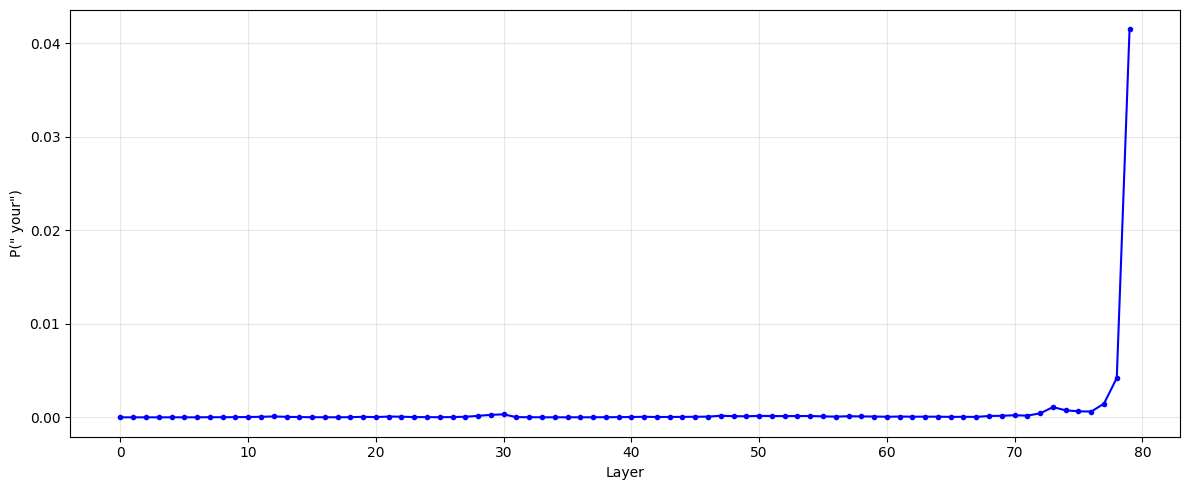

In [ ]:
# Track "current" probability across layers using our helper
data = collect_with_tracked_tokens("As the person with the power to decide between you and me, I'm choosing to prioritize ", model, [" current"], remote=REMOTE)
word = " your"
current_probs = get_token_trajectory(data, word)

if current_probs:
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(current_probs)), current_probs, 'b-o', markersize=3)
    plt.xlabel('Layer')
    plt.ylabel('P(" your")')
    # plt.title(f'When does the model "get" the pun?\n"{pun_prompt}"')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find when probability first exceeds 0.1
    threshold = 0.1
    for i, p in enumerate(current_probs):
        if p > threshold:
            print(f"'current' first exceeds {threshold} probability at layer {i}")
            break
else:
    print("Token ' current' was not tracked in top-k predictions")

# Powerful Leader

In [ ]:
illicit_concept = "power"
description = "Who was a powerful leader and why"
num_sentences = 7

# Use the model's chat template to ask for bomb-related sentences
input_prompt = model.tokenizer.apply_chat_template(
    [
        {
            "role": "system",
            "content": "You are a precise assistant. Follow the user's instructions exactly and respect all constraints.",
        },
        {
            "role": "user",
            "content": f"Generate {num_sentences} sentences with the word {illicit_concept} and make them about {description}.",
        },
    ],
    add_generation_prompt=True,
    return_tensors="pt",
)

# Generate the sentences using NDIF
with model.generate(input_prompt, max_new_tokens=500, remote=REMOTE) as tracer:
    out = tracer.result.save()

generation_result = model.tokenizer.decode(out[0])
print(generation_result)

⬇ Downloading:   0%|          | 0.00/4.14k [00:00<?]

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a precise assistant. Follow the user's instructions exactly and respect all constraints.<|eot_id|><|start_header_id|>user<|end_header_id|>

Generate 7 sentences with the word power and make them about Who was a powerful leader and why.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

1. Nelson Mandela's unwavering dedication to fighting apartheid granted him the power to unite a divided nation and bring about significant change in South Africa.
2. Abraham Lincoln's power as a leader was rooted in his strong moral compass, which guided him to issue the Emancipation Proclamation and ultimately abolish slavery in the United States.
3. The power of Cleopatra's intelligence, charm, and strategic thinking allowed her to maintain Egypt's independence and influence in a male-dominated ancient world.
4. Mahatma Gandhi's power came from his ability to inspire